In [64]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/style-transfer-data/Style_transfer/Content_1.jpg
/kaggle/input/style-transfer-data/Style_transfer/Style.jpg
/kaggle/input/style-transfer-data/Style_transfer/Content.jpg


In [65]:
from PIL import Image
import numpy as np 
import os
import torch

In [66]:
!pwd

/kaggle/working


In [67]:
path2content = "../input/style-transfer-data/Style_transfer/Content_1.jpg"
path2style = "../input/style-transfer-data/Style_transfer/Style.jpg"

In [68]:
import torchvision.transforms as transforms

h,w = 256, 384
mean_rgb = (0.485, 0.456, 0.406)
std_rgb = (0.229, 0.224, 0.225)

transformer = transforms.Compose([
    transforms.Resize((h,w)),
    transforms.ToTensor(),
    transforms.Normalize(mean_rgb, std_rgb)
])

In [69]:
content_img = Image.open(path2content)
style_img = Image.open(path2style)

torch.Size([3, 256, 384]) False
torch.Size([3, 256, 384]) False


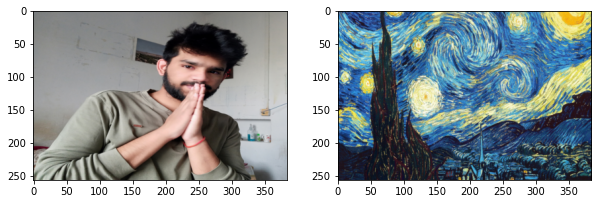

In [70]:
content_tensors = transformer(content_img)
print(content_tensors.shape, content_tensors.requires_grad)

style_tensors = transformer(style_img)
print(style_tensors.shape, style_tensors.requires_grad)

import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image


def imgtensors2pil(img_tensor):
    img_tensor_c = img_tensor.clone().detach()
    img_tensor_c*= torch.tensor(std_rgb).view(3,1,1)
    img_tensor_c+= torch.tensor(mean_rgb).view(3,1,1)
    img_tensor_c = img_tensor_c.clamp(0,1)
    img_pil = to_pil_image(img_tensor_c)
    
    return img_pil
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(imgtensors2pil(content_tensors))
plt.subplot(1,2,2)
plt.imshow(imgtensors2pil(style_tensors))

Specifically, the neural style transfer algorithm works as follows:
1. Take a pretrained classification model (for example, VGG19), remove the last
layers, and keep the remaining layers to serve as a feature extractor.
2. Feed the content image to the model and get selected features to serve as the
target content.
3. Feed the style image to the model and get the Gram matrix of selected features to
serve as the target style.
4. Feed the input to the model and get the features and the Gram matrix of selected
features to serve as the predicted content and style, respectively.
5. Compute the content and style errors, and use this information to update the
input and reduce the error.
6. Repeat step 4 until the error is minimized.

In [71]:
import torchvision.models as models

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model_vgg = models.vgg19(pretrained=True).features.to(device).eval()

In [72]:
print(model_vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [73]:
def get_features(x, model, layers):
    features = {}
    for name, layer in enumerate(model.children()):
        x = layer(x)
        if str(name) in layers:
            features[layers[str(name)]] = x
    return features


    
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n*c, h*w)
    gram = torch.mm(x, x.t())
    return gram

def get_content_loss(pred_features, target_features, layer):
    target = target_features[layer]
    pred = pred_features[layer]
    loss = F.mse_loss(pred, target)
    
    return loss


def get_style_loss(pred_features, target_features, style_layer_dict):
    loss = 0
    for layer in style_layer_dict:
        pred_fea = pred_features[layer]
        pred_gram = gram_matrix(pred_fea)
        n,c,h,w = pred_fea.shape
        target_gram = gram_matrix(target_features[layer])
        layer_loss = style_layer_dict[layer]*F.mse_loss(pred_gram, target_gram)
        loss += layer_loss/(n*c*h*w)
    return loss




In [74]:
feature_layers = {'0': 'conv1_1',
'5': 'conv2_1',
'10': 'conv3_1',
'19': 'conv4_1',
'21': 'conv4_2',
'28': 'conv5_1'}

In [75]:
con_tensor = content_tensors.unsqueeze(0).to(device)

sty_tensor = style_tensors.unsqueeze(0).to(device)

content_features = get_features(con_tensor, model_vgg, feature_layers)


style_features = get_features(sty_tensor, model_vgg, feature_layers)

### Optimizer and Alogorithm

In [76]:
input_tensor = con_tensor.clone().requires_grad_(True)

from torch import optim
import torch.nn.functional as F
optimizer = optim.Adam([input_tensor], lr = 0.01)

In [77]:
num_epochs = 1000
content_weight = 2
content_layer = "conv5_1"
style_weight = 5e5
style_layers_dict = { 'conv1_1': 0.75,
'conv2_1': 0.5,
'conv3_1':0.25,
'conv4_1': 0.25,
'conv5_1': 0.25
                    }

feature_layers = {'0': 'conv1_1',
'5': 'conv2_1',
'10': 'conv3_1',
'19': 'conv4_1',
'21': 'conv4_2',
'28': 'conv5_1'}

epoch 0, content loss: 0.0, style loss5.5e+02
epoch 1, content loss: 0.16, style loss5.3e+02
epoch 2, content loss: 0.43, style loss5.1e+02
epoch 3, content loss: 0.67, style loss4.9e+02
epoch 4, content loss: 0.91, style loss4.6e+02
epoch 5, content loss: 1.1, style loss4.4e+02
epoch 6, content loss: 1.4, style loss4.1e+02
epoch 7, content loss: 1.6, style loss3.9e+02
epoch 8, content loss: 1.8, style loss3.7e+02
epoch 9, content loss: 1.9, style loss3.5e+02
epoch 10, content loss: 2.1, style loss3.3e+02
epoch 11, content loss: 2.2, style loss3.1e+02
epoch 12, content loss: 2.3, style loss3e+02
epoch 13, content loss: 2.4, style loss2.9e+02
epoch 14, content loss: 2.5, style loss2.7e+02
epoch 15, content loss: 2.5, style loss2.6e+02
epoch 16, content loss: 2.6, style loss2.5e+02
epoch 17, content loss: 2.7, style loss2.4e+02
epoch 18, content loss: 2.7, style loss2.3e+02
epoch 19, content loss: 2.8, style loss2.2e+02
epoch 20, content loss: 2.8, style loss2.1e+02
epoch 21, content los

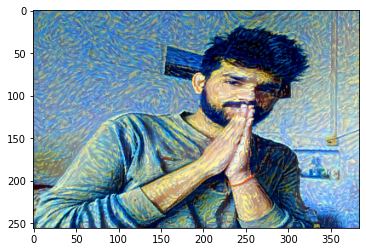

In [78]:
A = []
for epoch in range(num_epochs+1):
    optimizer.zero_grad()
    input_features = get_features(input_tensor,model_vgg, feature_layers)
    
    content_loss = get_content_loss(input_features,get_features(con_tensor, model_vgg, feature_layers),content_layer)
    
    style_loss = get_style_loss(input_features,get_features(sty_tensor, model_vgg, feature_layers),style_layers_dict)
    
    neural_loss = content_weight*content_loss + style_weight*style_loss
    
    neural_loss.backward(retain_graph = True)
    
    optimizer.step()
    
    print('epoch {}, content loss: {:.2}, style loss{:.2}'.format(epoch,content_loss, style_loss))
    
    if epoch % 200 == 0:
        A.append(np.array(imgtensors2pil(input_tensor[0].cpu())))
        plt.imshow(imgtensors2pil(input_tensor[0].cpu()));
    

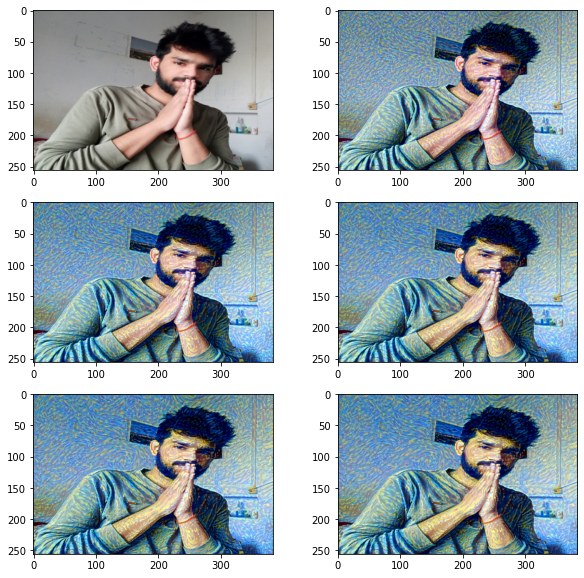

In [79]:
plt.figure(figsize=(10,10))
for i in range(len(A)):
    plt.subplot(3,2,i+1)
    plt.imshow(A[i])


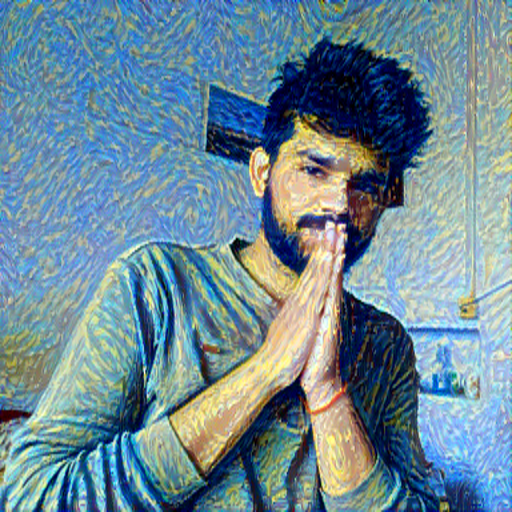

In [91]:
Image.fromarray(A[5]).resize((512,512))